In [1]:
library(assertthat)
library(dplyr)
library(purrr)
library(ggraph)
library(ggmap)
library(ggplot2)
library(igraph)
library(rjson)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.


Attaching package: 'igraph'


The following objects are masked from 'package:purrr':

    compose, simplify


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




## Read in Traffic Data for 4th Quarter Winter, December

In [ ]:
santa_filename <- "los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
filepath <- "santa_data"
santa_df <- read.csv(file.path(filepath, santa_filename),stringsAsFactors=FALSE,header=TRUE)

In [ ]:
geo_filename <- "los_angeles_censustracts.json"
geodata_json <- fromJSON(file=file.path(filepath, geo_filename))

In [ ]:
edge_list <- santa_df[santa_df$month==12,c("sourceid","dstid","mean_travel_time")]
names(edge_list) <- c("src","dst","weight")

In [ ]:
location_graph <- graph_from_data_frame(edge_list,directed=FALSE)

## Get the Addresses and Longitude and Latitude

In [ ]:
V(location_graph)$centroid_x <- NA
V(location_graph)$centroid_y <- NA
V(location_graph)$location_id <- NA

In [ ]:
key <- names(read.delim('C:/Users/lpott/Desktop/geolocation_key.txt'))
register_google(key = key)

In [ ]:
for (feature in geodata_json$features){
    centroid <- colMeans(matrix(unlist(feature$geometry$coordinates),ncol=2,byrow=TRUE))
    vertex_id <- feature$properties$MOVEMENT_ID

    if (!(vertex_id %in% V(location_graph)$name)){
        next
    }
    #set.vertex.attribute(location_graph,'centroid',vertex_id,centroid)
    V(location_graph)[vertex_id]$location_id <- revgeocode(c(centroid[1],centroid[2]),output='address')
    V(location_graph)[vertex_id]$centroid_x <- centroid[1]
    V(location_graph)[vertex_id]$centroid_y <- centroid[2]
}

In [2]:
#save.image(file="open_ended.RData")
load(file="open_ended.RData")

## Simplify the graph by removing isolated nodes and aggregating multiple edge

In [3]:
los_angeles_nodes <- V(location_graph)$name[sapply( V(location_graph)$location_id,function (x){grepl( "Los Angeles", x, fixed = TRUE)})]

In [4]:
los_angeles_graph <- induced.subgraph(location_graph,los_angeles_nodes)

In [5]:
sprintf("Los Angeles Nodes %d Edge %d",vcount(los_angeles_graph),ecount(los_angeles_graph))

[1] "Los Angeles Nodes 633 Edge 296254"

In [6]:
cl<-clusters(los_angeles_graph)
largest_g<-induced.subgraph(los_angeles_graph, which(cl$membership == which.max(cl$csize)))

In [7]:
location_graph_simplified <- simplify(largest_g, edge.attr.comb="mean",remove.loops=TRUE)

In [8]:
sprintf("# Nodes: %d , # Edges: %d",vcount(location_graph_simplified),ecount(location_graph_simplified))

[1] "# Nodes: 633 , # Edges: 157232"

## Convert the graph to a directed graph

In [9]:
location_graph_directed <- as.directed(location_graph_simplified,'mutual')

In [10]:
sprintf("# Nodes: %d , # Edges: %d",vcount(location_graph_directed),ecount(location_graph_directed))

[1] "# Nodes: 633 , # Edges: 314464"

## Initialize Graph for Linear Threshold Model

In [11]:
library(stringr)

In [12]:
# invert the edge weight, as we want far distance (high weight) to have little influence
E(location_graph_directed)$weight <- 1/E(location_graph_directed)$weight

# normalize the edge weights, such that the sum of all the in edges is 1
E(location_graph_directed)$weight <- E(location_graph_directed)$weight / strength(location_graph_directed, mode="in")[get.edgelist(location_graph_directed)[,2]]

### linear threshold model algorithm

In [99]:
trials <- 1000
time_steps <- 75
active_set_sizes <- c(5,10,15,20,25,30,45,50)
results_list <- vector(mode = "list", length = length(active_set_sizes))
names(results_list) <- as.character(active_set_sizes)

In [ ]:
for (active_set_size in c(5,10,15,20,25,30,45,50)){
    ptm <- proc.time()

#     print(sprintf("===================Active Set Size %d=================",active_set_size))
#     flush.console()
    # select a random amount of nodes for target size to activate... based on heuristics ...
    
    n_initial_nodes <- active_set_size
    start_nodes <- names(sort(degree(location_graph_directed),decreasing=TRUE)[1:n_initial_nodes])
    active_counts <- matrix(nrow=trials,ncol=time_steps)
    
    for (T in seq_len(trials)){
#         ptm <- proc.time()
        # each node has a latent threshold to become active from influence of neighbors
        V(location_graph_directed)$theta <- runif(vcount(location_graph_directed))
        thresholds <- V(location_graph_directed)$theta

        # change the active status to ON!, and initialize first active nodes!
        V(location_graph_directed)$active <- 0
        V(location_graph_directed)[start_nodes]$active <- 1

        # get directed weighted adjacency matrix
        adjacency_matrix <- get.adjacency(location_graph_directed,attr='weight')

        # apply algorithm for T time steps
        for (t in seq_len(time_steps)){
    #         print(sprintf("===================Time Step %d=================",t))

    #         ptm <- proc.time()

            sweeped_data <- sweep(adjacency_matrix,MARGIN=2,V(location_graph_directed)$active,'*')
            new_active <- as.integer(Matrix::rowSums(sweeped_data) > thresholds) |  V(location_graph_directed)$active
            V(location_graph_directed)$active <- new_active


    #         print_string <- sprintf("elapsed time %.4f",(proc.time() - ptm)[1])
    #         print(print_string)
    #         flush.console()
            active_counts[T,t] <- sum(new_active)
        }
#         print(sprintf("===================Trial %d ---- Time %.5f=================",T,(proc.time() - ptm)[1]))
#         flush.console()
    }
    print(sprintf("===================Active Set Size %d ---- Time %.5f=================",active_set_size,(proc.time() - ptm)[1]))
    flush.console()
    results_list[[as.character(active_set_size)]] <- active_counts
}

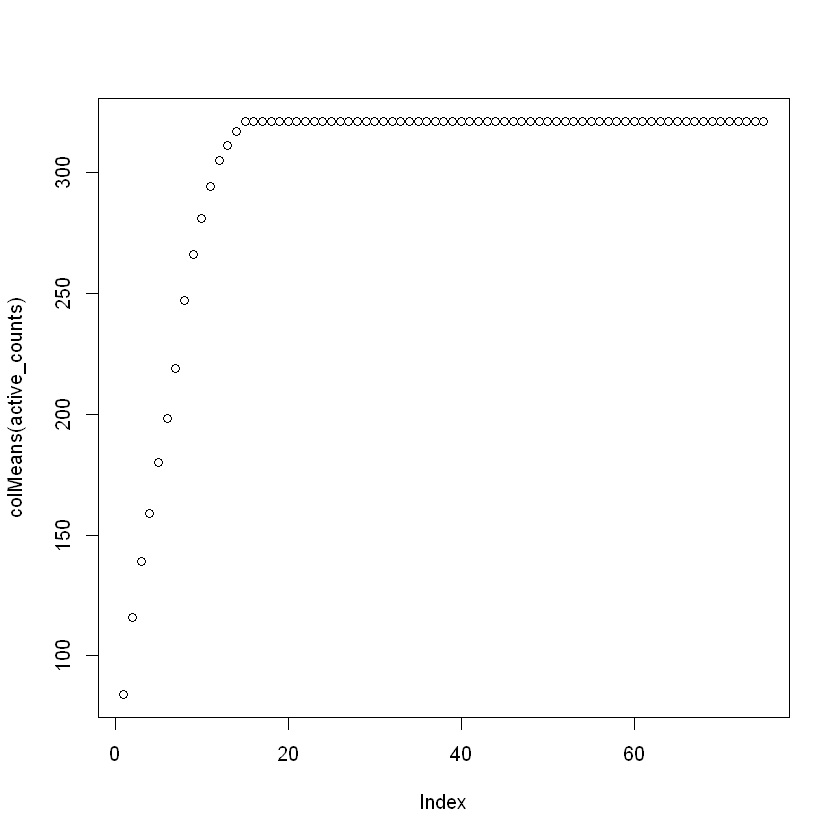

In [96]:
plot(colMeans(active_counts))